# Machine learning
Dataset `spam` - Apprentissage / Validation / Test

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

from xgboost import XGBClassifier

## 1. Données

### 1.1 Importation

In [ ]:
repert = '/content/'
# repert = '' # Sur Google collab ou Onyxia

data = pd.read_csv(repert + 'spam.csv',
                   header=0,
                   sep=',',
                   decimal='.')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [ ]:
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_semicolon,char_freq_leftbrac,char_freq_leftsquarebrac,char_freq_exclaim,char_freq_dollar,char_freq_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### 1.2. Gestion des variables

In [ ]:
target = 'spam'
features = list(data.columns.difference([target]))

X = data[features]
y = data[target]

### 1.3. Création d'un échantillon test

In [ ]:
test_portion = 1/5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_portion, shuffle=True)

print('Dimensions X_train :', X_train.shape)
print('Dimensions X_test  :', X_test.shape)
print('Dimensions y_train :', y_train.shape)
print('Dimensions y_test  :', y_test.shape)

Dimensions X_train : (3680, 57)
Dimensions X_test  : (921, 57)
Dimensions y_train : (3680,)
Dimensions y_test  : (921,)


### 1.4. Normalisation des données

On considère le jeu de données normalisé pour les méthodes qui le requièrent.

In [ ]:
mean_std_scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train)

X_train_sc = mean_std_scaler.transform(X_train)
X_test_sc = mean_std_scaler.transform(X_test)

### 1.5. Statistiques de base

In [ ]:
data.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_semicolon,char_freq_leftbrac,char_freq_leftsquarebrac,char_freq_exclaim,char_freq_dollar,char_freq_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


## 2. Modélisation

In [ ]:
criteria = 'accuracy' # Pour le choix du critère CV (exactitude)
n_folds  = 10         # Pour le nombre de blocs CV (10)
n_core   = -1         # Pour l'utilisation de tous les core disponibles
verbose  = 1          # Pour le caractère "verbeux"

### 2.1. CART

Avec un "petit" arbre (profondeur maximale de 2) :

In [ ]:
cart_model = DecisionTreeClassifier(max_depth=2)
cart = cart_model.fit(X_train, y_train)

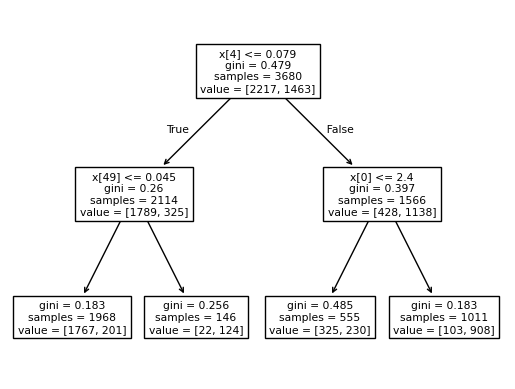

In [ ]:
plot_tree(cart)
plt.show()

In [ ]:
y_test_pred_cart = cart.predict(X_test)
y_test_prob_pred_cart = cart.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix_cart = confusion_matrix(y_test, y_test_pred_cart)
print('Matrice de confusion CART :\n', confusion_matrix_cart)

accuracy_cart = accuracy_score(y_test, y_test_pred_cart)
print(f'Exactitude CART : {accuracy_cart:.2f}')

auc_cart = roc_auc_score(y_test, y_test_prob_pred_cart)
print(f'AUC CART : {auc_cart:.2f}')

Matrice de confusion CART :
 [[534  37]
 [115 235]]
Exactitude CART : 0.83
AUC CART : 0.86


Avec un "grand" arbre :

In [ ]:
start_time_cart = time.time()

In [ ]:
cart_model = DecisionTreeClassifier()
cart = cart_model.fit(X_train, y_train)

In [ ]:
y_test_pred_cart = cart.predict(X_test)
y_test_prob_pred_cart = cart.predict_proba(X_test)[:, 1]

In [ ]:
end_time_cart = time.time()
execution_time_cart = end_time_cart - start_time_cart
print(f"Temps d'exécution CART : {execution_time_cart:.2f} secondes")

Temps d'exécution CART : 5.63 secondes


In [ ]:
confusion_matrix_cart = confusion_matrix(y_test, y_test_pred_cart)
print('Matrice de confusion CART :\n', confusion_matrix_cart)

accuracy_cart = accuracy_score(y_test, y_test_pred_cart)
print(f'Exactitude CART : {accuracy_cart:.2f}')

auc_cart = roc_auc_score(y_test, y_test_prob_pred_cart)
print(f'AUC CART : {auc_cart:.2f}')

Matrice de confusion CART :
 [[517  54]
 [ 35 315]]
Exactitude CART : 0.90
AUC CART : 0.90


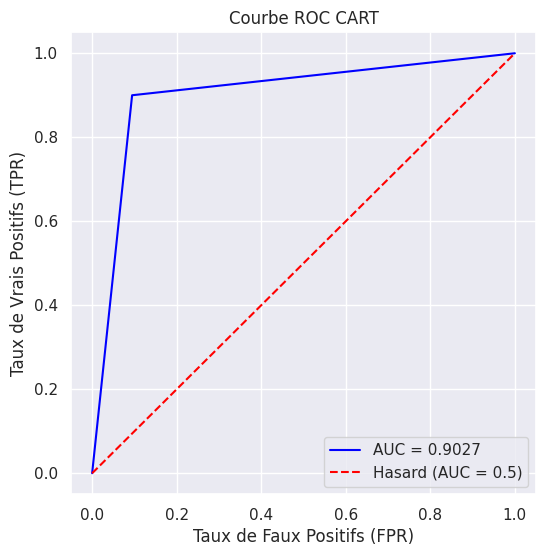

In [ ]:
fpr_cart, tpr_cart, thresholds_cart = roc_curve(y_test, y_test_prob_pred_cart)

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr_cart, tpr_cart, label=f'AUC = {auc_cart:.4f}', color='blue')
ax.plot([0, 1], [0, 1], '--', label='Hasard (AUC = 0.5)', color='red')
ax.set_xlabel('Taux de Faux Positifs (FPR)')
ax.set_ylabel('Taux de Vrais Positifs (TPR)')
ax.legend()
ax.set_title('Courbe ROC CART')
plt.show()

### 2.2. Random forest

In [ ]:
start_time_rf = time.time()

In [ ]:
rf_model = RandomForestClassifier()

params_rf = {
    'n_estimators': [250, 500, 750, 1000]
}

rf = GridSearchCV(estimator=rf_model,
                  param_grid=params_rf,
                  scoring=criteria,
                  cv=n_folds,
                  n_jobs=n_core,
                  verbose=verbose)

rf.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [250, 500, 750, 1000]},
             scoring='accuracy', verbose=1)

In [ ]:
y_test_pred_rf = rf.predict(X_test)
y_test_prob_pred_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
end_time_rf = time.time()
execution_time_rf = end_time_rf - start_time_rf
print(f"Temps d'exécution Random forest : {execution_time_rf:.2f} secondes")

Temps d'exécution Random forest : 226.60 secondes


In [ ]:
print('Hyperparamètre optimal Random forest :', rf.best_params_)

Hyperparamètre optimal Random forest : {'n_estimators': 250}


In [ ]:
confusion_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print('Matrice de confusion Random forest :\n', confusion_matrix_rf)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f'Exactitude Random forest : {accuracy_rf:.2f}')

auc_rf = roc_auc_score(y_test, y_test_prob_pred_rf)
print(f'AUC Random forest : {auc_rf:.2f}')

Matrice de confusion Random forest :
 [[551  20]
 [ 24 326]]
Exactitude Random forest : 0.95
AUC Random forest : 0.98


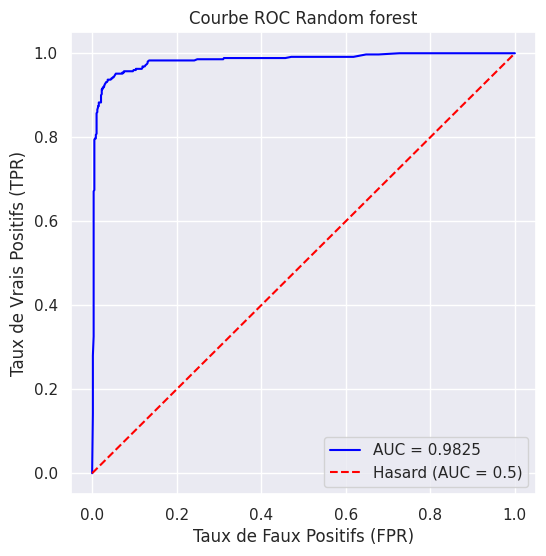

In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_test_prob_pred_rf)

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_rf:.4f}', color='blue')
ax.plot([0, 1], [0, 1], '--', label='Hasard (AUC = 0.5)', color='red')
ax.set_xlabel('Taux de Faux Positifs (FPR)')
ax.set_ylabel('Taux de Vrais Positifs (TPR)')
ax.legend()
ax.set_title('Courbe ROC Random forest')
plt.show()